# CPSC 330 Lecture 13

### Lecture plan

- 👋
- **Turn on recording**
- Announcements
- Intro to computer vision (5 min)
- Intro to neural networks (15 min)
- Neural networks for images (15 min)
- Pre-trained networks (5 min)
- Break (5 min)
- Transfer learning (15 min)
- Bias and AI safety (20 min)

# TODO

- move bias / ai safety to ethics lecture
- here, add a section on multi-class classification and a section on imagenet

In [1]:
import pandas as pd
import numpy as np

import os 

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn import datasets

In [2]:
plt.rcParams['font.size'] = 16

In [12]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras import utils
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

## Announcements

- 

## Recap of last time

- Intro to NLP.
- We focussed on turning text into features.
- Aside: sparse matrices.
- Preprocessing.
- Word embeddings.
- In hw6 you will use these for supervised learning.

## Intro to computer vision

- [Computer vision](https://en.wikipedia.org/wiki/Computer_vision) refers to understanding images/videos, usually using ML/AI. 
- Like NLP, computer vision has many tasks of interest:
  - image classification: is this a cat or a dog?
  - object localization: where are the people in this image?
  - image segmentation: what are the various parts of this image?
  - motion detection: what moved between frames of a video?
  - and much more...
- We will focus on image classification.

## Intro to neural networks (15 min)

- Remember the `Pipeline`? 
- A neural network is a model that's sort of like its own pipeline.
  - It involves a series of transformations ("layers") internally. 
  - The output is the prediction.
- The code looks like this:

In [4]:
model = Sequential()
model.add(Dense(10, input_dim=1, activation='tanh'))
model.add(Dense(15, activation='tanh'))
model.add(Dense(1, activation='linear'))

- Each time we do `model.add` we are adding on one of those transformations.
- Imporant question: how many features before/after transformation.
  - e.g. scaling doesn't change the number of features
  - OHE increases the number of features
- With a neural net, you specify the number of features after each transformation.
  - In the above, it goes from 1 to 10 to 15 to 1.

Note: in scikit-learn, we use one line of Python code to set up the model and set the hyperparameters. For example:


In [5]:
lr = LogisticRegression(C=5)

- In tensorflow.keras (the package we're using), we use multiple lines of Python code to set up the model.
- This design decision just makes the code more human-readable.
- One line of code per layer of the network.
- But there's nothing fundamental about it, one could also put the architecture/hypers on one line, in a file, etc.

- Next, with tensorflow, we have an extra step not present in sklearn, called `compile`.
- Let's ignore this for now.

In [6]:
model.compile(loss='mean_squared_error', optimizer="adam")

Let's try it out on some made up data:

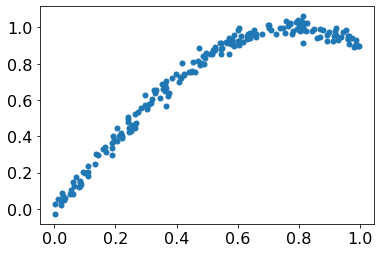

In [7]:
np.random.seed(5)
N = 200
X = np.random.rand(N,1)
y = np.sin(2*X) + np.random.randn(N,1)*0.03

plt.plot(X,y,'.',markersize=10);

The rest is what we're used to: `fit`, `predict`, etc. 

In [8]:
model.fit(X, y, epochs=1000, verbose=0);

(Note how even fitting such a simple dataset can be slow with neural networks.)

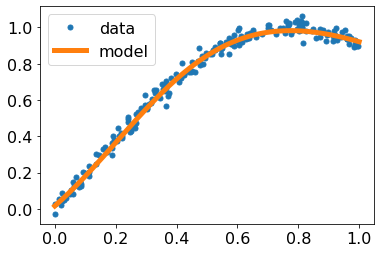

In [9]:
plt.plot(X,y,'.',markersize=10,label="data")
grid = np.linspace(0,1,1000)[:,None]
plt.plot(grid, model.predict(grid),linewidth=5,label="model")
plt.legend();

Instead of `score` we use `evaluate`:

In [10]:
model.evaluate(X, y, verbose=0)

0.0009070498635992408

#### Terminology

- Neural network = neural net
- Deep learning ~ using neural networks

#### Why neural networks?

- They can learn very complex functions.
  - The fundamental tradeoff is primarily controlled by the **number of layers** and **layer sizes**.
  - More layers / bigger layers --> more complex model.
  - You can generally get a model that will not underfit.
- The work really well for structured data:
  - 1D sequence, e.g. timeseries, language
  - 2D image
  - 3D image or video
- They've had some incredible successes in the last 10 years.
- Transfer learning (coming later today) is really useful.

#### Why not neural networks?

- Often they require a lot of data.
- They require a lot of compute time, and, to be faster, specialized hardware called [GPUs](https://en.wikipedia.org/wiki/Graphics_processing_unit).
- They have huge numbers of hyperparameters are a huge pain to tune.
  - Think of each layer having hyperparameters, plus some overall hyperparameters.
  - Being slow compounds this problem.
- They are not interpretable.
- When you call `fit`, you are not guaranteed to get the optimal.
  - There are now a bunch of hyperparameters specific to `fit`, rather than the model.
  - You never really know if `fit` was successful or not.
  - You never really know if you should have run `fit` for longer.
- I don't recommend training them without further training (ha)
  - Take CPSC 340 and other courses if you're interested.
  - I'll show you some ways to use neural networks without calling `fit`.

#### Deep learning software

- scikit-learn has [MLPRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html) and [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) but they aren't very flexible.
  - In general you'll want to leave the scikit-learn ecosystem when using neural networks.
  - Fun fact: these classes were contributed to scikit-learn by a UBC graduate student.
- There's been a lot of deep learning software out there.
- The current big players are:

1. [TensorFlow 2.0](https://www.tensorflow.org)
2. [PyTorch](http://pytorch.org)

- Both are heavily used in industry.
- A lot of people I talk to say PyTorch is easier to use.
  - However, I started teaching this in MDS 4 years ago, before PyTorch was created!
- If interested, see [comparison of deep learning software](https://en.wikipedia.org/wiki/Comparison_of_deep_learning_software).

## Neural networks for images (10 min)

- Let's load the MNIST handwritten digits dataset.
- It's a very boring dataset by now - we can get extremely high accuracy, and we've probably overfit to the test set by now.
- But it's a good example to see.

In [14]:
# the data, shuffled and split between train and test sets
(X_train_img, y_train), (X_test_img, y_test) = mnist.load_data()

In [15]:
X_train_img.shape

(60000, 28, 28)

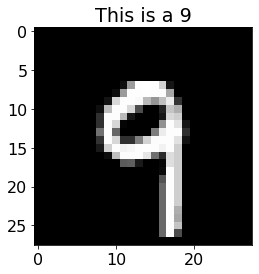

In [16]:
# display a random training example
i = np.random.randint(0,len(X_train_img))
plt.imshow(X_train_img[i],cmap='gray')
plt.title('This is a %d' % y_train[i]);

In [17]:
type(X_train_img[i])

numpy.ndarray

In [18]:
X_train_img[i].shape

(28, 28)

In [19]:
X_train_img.shape

(60000, 28, 28)

- How can we take our input ($28\times 28$ numpy array) and map it out our output (a label $0,1,\ldots,9$)?
- Most naive approach: "flatten" the images, and then use whatever supervised learning method we feel like.

In [20]:
X_train = X_train_img.reshape(60000, 28*28)
X_test = X_test_img.reshape(10000, 28*28)
X_train = X_train / 255 # this is the same a min/max scaling, since the pixel intensities range from 0 to 255
X_test = X_test / 255

print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

60000 train samples
10000 test samples


In [21]:
X_train.shape

(60000, 784)

In [22]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

Note: I secretly introduced multi-class classification here.

# TODO -add a bit more on this

Now we can use our usual classification methods:

In [23]:
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs')

Note: setting `multi_class="multinomial"` because we have more than 2 classes.

In [24]:
lr.fit(X_train, y_train);

/opt/miniconda3/envs/cpsc330env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [25]:
lr.score(X_train, y_train)

0.93505

In [26]:
lr.score(X_test, y_test)

0.9258

In [27]:
z = np.array([[1,2],[3,4]])

In [28]:
z

array([[1, 2],
       [3, 4]])

In [29]:
z.shape

(2, 2)

In [30]:
np.reshape(z, (4,))

array([1, 2, 3, 4])

- Why is this a bad idea?
  - By "flattening" the image we throw away useful information.
- What the computer sees:

In [31]:
list(X_train[0])[150:200]

[0.0,
 0.0,
 0.011764705882352941,
 0.07058823529411765,
 0.07058823529411765,
 0.07058823529411765,
 0.49411764705882355,
 0.5333333333333333,
 0.6862745098039216,
 0.10196078431372549,
 0.6509803921568628,
 1.0,
 0.9686274509803922,
 0.4980392156862745,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.11764705882352941,
 0.1411764705882353,
 0.3686274509803922,
 0.6039215686274509,
 0.6666666666666666,
 0.9921568627450981,
 0.9921568627450981,
 0.9921568627450981,
 0.9921568627450981,
 0.9921568627450981,
 0.8823529411764706,
 0.6745098039215687,
 0.9921568627450981,
 0.9490196078431372,
 0.7647058823529411,
 0.25098039215686274,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

- Hard to classify this!
- [Convolutional neural networks](https://en.wikipedia.org/wiki/Convolutional_neural_network) (CNNs) can take in images without flattening them.
  - We won't cover CNNs here, but they are in CPSC 340.

## Break (5 min)

## Using pre-trained networks (5 min)

- `tf.keras` has a bunch of pre-trained computer vision models available, see [here](https://keras.io/applications/).
- Here we load a pre-trained model (uses our internet connection).
- The amazing part is how much effort went into this base model. 
  - An insane amount of labelled data.
  - An insane amount of compute time.
  - An insane amount of human effort tuning the model.

In [ ]:
resnet = ResNet50(weights='imagenet')

Note the important distinction between the choice of architecture (in this case, `ResNet50`) and the choice of dataset (in this case, ImageNet).

Here's my graduation photo from undergrad:

In [ ]:
img_path = 'data/gelbart-michael-adam.jpg'
img = load_img(img_path, target_size=(224, 224))
plt.imshow(img);

In [ ]:
x = img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = resnet.predict(x)
decode_predictions(preds, top=3)[0]

In [ ]:
img_path = 'data/office.jpg'
img = load_img(img_path, target_size=(224, 224))
plt.imshow(img);

In [ ]:
x = img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = resnet.predict(x)
decode_predictions(preds, top=3)[0]

- We got these predictions without "doing the ML ourselves".
- Can be useful for cases like sentiment analysis.
- In fact, that is what we did last class with the word-embeddings! 
  - And, it was indeed also a deep learning model that was used there.

## Transfer learning (15 min)

- Let's look at the [Kaggle dog breed identification](https://www.kaggle.com/c/dog-breed-identification/data) dataset. 
- But let's imagine we only have 2000 examples, to simulate only having a small dataset available to us.

In [ ]:
data = pd.read_csv('data/dog-breed-identification/labels.csv')
data = data[:2000]
data['image_path'] = data.apply( lambda row: (os.path.join("data/dog-breed-identification/train", row["id"] + ".jpg") ), axis=1)
data.head()

Above: you can see some of the breeds that we're predicting.

In [ ]:
target_labels = data['breed']
total_classes = len(set(target_labels))
print("number of dog breeds:", total_classes)

In [ ]:
# read images from the image directory. 
images = np.array([img_to_array(
                    load_img(img, target_size=(256,256))
                    ) for img in data['image_path'].values.tolist()])

In [ ]:
images.shape

Above: we have 2000 images, each of size $256 \times 256$ and with 3 colour channels.

In [ ]:
images = images.astype('float32')/255.0 

Above: it's very important to scale the images!

In [ ]:
plt.imshow(images[0]);
plt.grid(True);
plt.xticks([]);
plt.yticks([]);
plt.title("Breed = " + target_labels[0]);

Above: this is a sample image from the dog breed data set.

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(images, target_labels, 
                                                    stratify=np.array(target_labels), 
                                                    random_state=42)

In [ ]:
print(X_train.shape)
print(X_valid.shape)

The dataset seems fairly balanced:

In [ ]:
target_labels.value_counts()

Meaning DummyClassifier gets a horrible accuracy:

In [ ]:
dc = DummyClassifier(strategy='prior')
dc.fit(X_train, y_train);

In [ ]:
dc.score(X_train, y_train)

In [ ]:
dc.score(X_valid, y_valid)

We have roughly $1500/120=12.5$ images per class. **This is tiny compared to what we're used to.** What can we do??

- We can use **transfer learning**.
- We'll use a model trained on one task as a starting point for learning to perform another task. 
- Why is transfer learning helpful to us? Why can't we just train a model with the second task's objectives from the beginning? 
  - It's difficult to obtain labeled data: ususally we need a whole lot of data in order to solve complex problems, and it can be hard to collect the data.

In [ ]:
base_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

- Note the `include_top=False`. 
- This throws away the last layer. 
- It wasn't useful to us anyway. 
- ImageNet has 1000 classes, but we're not interested in those classes. 
- We don't want their predictions; we want every step in their "pipeline" except the predictions.
- We will the feature extractor and then train our own model from the tools we know.

- The next line turns the pre-trained model into something we can use.
- The syntax and details are out of scope here.

In [ ]:
feature_extractor = Model(inputs=base_inception.input, outputs=GlobalAveragePooling2D()(base_inception.output))

The next lines may take a long time:

In [ ]:
%%time
Z_train = feature_extractor.predict(X_train)
Z_valid = feature_extractor.predict(X_valid)

In [ ]:
Z_train.shape

In [ ]:
lr = LogisticRegression(multi_class="multinomial", solver="lbfgs")
lr.fit(Z_train, y_train);

In [ ]:
lr.score(Z_train, y_train)

In [ ]:
lr.score(Z_valid, y_valid)

# TODO- compare with logistic reg on flattened images

- This is an incredible accuracy for so little effort!!!
- I challenge you to get accuracy anywhere near this high with only 2000 examples using other methods, including deep learning!

## Bias and AI safety (20 min)

#### Bias

- Bias: we have similar problems as we had with NLP.
- These models are trained from huge datasets, we don't exactly know how they work.
- See, e.g. [this paper](https://arxiv.org/pdf/1711.11443.pdf), Figure 8.
- Discussion: how could this sort of bias affect peoples' lives negatively?

<br><br><br><br><br><br>

Where does bias come from?

- Biases could come from data (if data only has certain groups in certain situations).
- Biases could come from labels (always using label of "ball" for certain sports).
- Biases could come from learning method (model predicts "basketball" for black people more often than they appear in training data for basketball images).

#### Strange results

- See [this 2019 paper](https://arxiv.org/pdf/1809.04729.pdf) (from UBC), Figure 1.
- See [this 2018 blog post](https://medium.com/@jrzech/what-are-radiological-deep-learning-models-actually-learning-f97a546c5b98) on diagnosing cardiomegaly (enlarged heart).
  - The model learns that the portable scanner is used on sicker patients.

#### Feature importances to explain predictions

- See the README of the [LIME repo](https://github.com/marcotcr/lime).
- It can shade the images based on importance, like the above.
- Also works for other data types.

#### AI safety and adversarial examples

- See [this 2015 paper](https://arxiv.org/pdf/1412.6572.pdf), Figure 1, for whitebox software attack.
- See [this 2018 paper](https://arxiv.org/pdf/1712.09665.pdf), Figure 1, for whitebox **physical** attack. 
- If the input is a $1000\times 1000$ image, the input space is so big.
  - it is hard to imagine all the possible perturbations, so some of them work out.

#### Fake news and deepfakes

- You may have heard of [deepfakes](https://en.wikipedia.org/wiki/Deepfake).
- See [this 2020 article](https://www.theguardian.com/technology/2020/jan/13/what-are-deepfakes-and-how-can-you-spot-them).
  - which led me to this [hilarious 2019 deepfake video](https://www.youtube.com/watch?v=4GdWD0yxvqw&feature=emb_logo). 

#### Environmental impact

- Current methods require:
  – A lot of data.
  – A lot of time to train.
  – Many training runs to do hyper-parameter optimization.
- See [this 2019 paper](https://arxiv.org/pdf/1906.02243.pdf), Table 1, for the CO$_2$ emissions of training a sophisticated deep learning model.
  - Entire training procedure emits 5 times more CO2 than lifetime emission of a car, including making the car


#### Ending on a positive note: random cool stuff

- Style transfer: given a "content image" and a "style image", create a new image with the content of one and the style of the other.
  - Here is the [original paper from 2015](https://arxiv.org/pdf/1508.06576.pdf), see Figure 2.
  - Here are more in [this 2016 paper](https://arxiv.org/pdf/1601.04589.pdf); see, e.g. Figures 1 and 7.
  - This has been done for video as well; see [this video from 2016](https://www.youtube.com/watch?v=Khuj4ASldmU).
- Colourization: see [this 2016 project](http://iizuka.cs.tsukuba.ac.jp/projects/colorization/en/).
- Inceptionism: let the neural network "make things up"
  - [2015 article](https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html)
  - "Deep dream" [video from 2015](https://www.youtube.com/watch?v=dbQh1I_uvjo).